In [7]:
from gs_quant.session import GsSession, Environment
from gs_quant.risk import CarryScenario
from gs_quant.markets.portfolio import Portfolio
from gs_quant.instrument import IRSwap, IRSwaption
from gs_quant.markets import PricingContext
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(Environment.PROD, client_id=None, client_secret=None, scopes=('run_analytics',))

In [9]:
# create a swap which has a 1m floating frequency
swap = IRSwap('Pay', '10y', 'EUR', fixed_rate='ATM-5', floating_rate_frequency='1m', name='EUR10y')

# resolve the trade as of today to fix the dates and strike
swap.resolve()

# roll daily for 66 business days assuming both forward curve is realised and spot curve is realised
fwd_results = []
spot_results = []
r = range(0, 66, 6)
# by wrapping all the scenarios into one PricingContext we package all the requests into one call to GS
with PricingContext():
    for time_shift in r:
        with PricingContext(is_async=True), CarryScenario(time_shift=time_shift, roll_to_fwds=True):
            fwd_results.append(swap.price())
        with PricingContext(is_async=True), CarryScenario(time_shift=time_shift, roll_to_fwds=False):
            spot_results.append(swap.price())

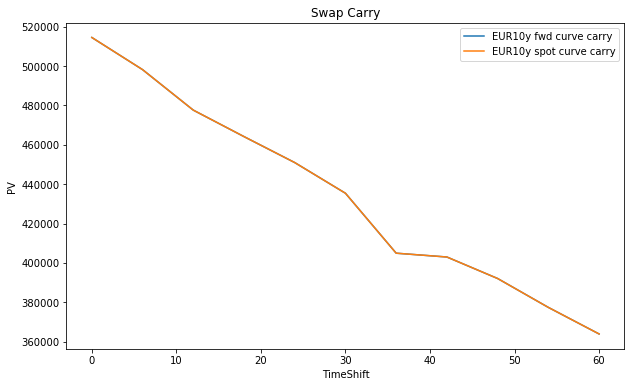

In [10]:
pd.Series([r.result() for r in fwd_results], index=r, dtype=np.dtype(float)).plot(figsize=(10, 6), 
                                                title='Swap Carry', 
                                                label='{} fwd curve carry'.format(swap.name))
pd.Series([r.result() for r in spot_results], index=r, dtype=np.dtype(float)).plot(label='{} spot curve carry'.format(swap.name))

plt.xlabel('TimeShift')
plt.ylabel('PV')
plt.legend()
# note that the steps represent the move in MTM as the cashflows are paid.  The libor fixing is implied from the fwd

In [11]:
itm_swaption = IRSwaption('Receive', '10y', 'EUR', strike='ATM+50', expiration_date='1m', name='ITM swaption')
otm_swaption = IRSwaption('Receive', '10y', 'EUR', strike='ATM-50', expiration_date='1m', name='OTM swaption')
port = Portfolio([itm_swaption, otm_swaption])
port.resolve()

# roll daily for 44 business days assuming both forward curve is realised and spot curve is realised
fwd_results = []
spot_results = []
r = range(0, 44, 4)
# by wrapping all the scenarios into one PricingContext we package all the requests into one call to GS
with PricingContext():
    for time_shift in r:
        with PricingContext(is_async=True), CarryScenario(time_shift=time_shift, roll_to_fwds=True):
            fwd_results.append(port.price())

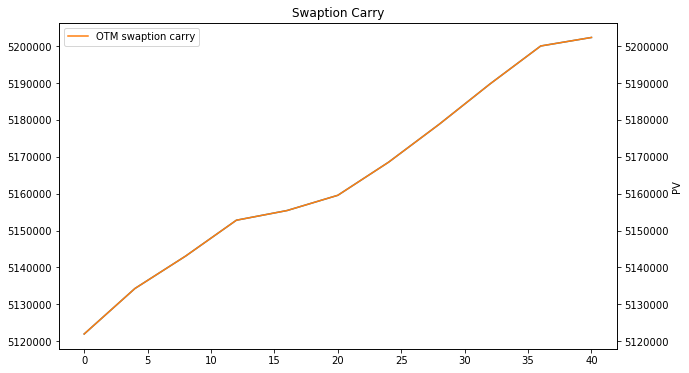

In [13]:
pd.Series([rs['ITM swaption'] for rs in fwd_results], index=r, dtype=np.dtype(float)).plot(figsize=(10, 6), 
                                             title='Swaption Carry', 
                                             label='{} carry'.format(itm_swaption.name))
pd.Series([rs['ITM swaption'] for rs in fwd_results], index=r, dtype=np.dtype(float)).plot(label='{} carry'.format(otm_swaption.name), secondary_y=True)

plt.xlabel('TimeShift')
plt.ylabel('PV')
plt.legend()
# note that the OTM swaption prices at 0 post expiry whereas the ITM swaption prices at the value of the swap.